In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def relu(x, derivative = False):
    res = x
    if derivative == True:
        return (res > 0)*1
    else:
        return res * (res > 0)

def sigmoid(x, derivative = False):
    res = 1/(1 + np.exp(-x))
    if derivative == True:
        return res * (1 - res)
    else:
        return res
    
def first_moment_update(previous_moment, grad, beta, timestep):
    biased = beta * previous_moment + (1 - beta) * grad
#     unbiased = biased / (1 - np.power(beta, timestep))
    return biased

def second_moment_update(previous_moment, grad, beta, timestep):
    biased = beta * previous_moment + (1 - beta) * np.square(grad)
#     unbiased = biased / (1 - np.power(beta,timestep))
    return biased

def forward_propagation(inputs, parameters, kl_weight = 5e-3):
    W_1, b_1, W_mu, b_mu, W_sigma, b_sigma, W_2, b_2 = parameters.values()
    
    z_1 = np.dot(inputs, W_1) + b_1
    a_1 = relu(z_1)
    z_mu = np.dot(a_1, W_mu) + b_mu
    z_sigma = np.dot(a_1, W_sigma) + b_sigma
    
#     eps = tf.random_normal(shape = tf.shape(z_mu)).numpy()
    eps = np.random.randn(len(inputs), n_z)
    sampled_vector = z_mu + np.multiply(np.exp(z_sigma * 0.5), eps)
    
    z_2 = np.dot(sampled_vector, W_2) + b_2
    
    cost = np.mean(np.square(inputs - z_2))
    loss_kl = 0.5*(np.sum(np.exp(z_sigma) + np.square(z_mu) - 1 - z_sigma, axis=1))
    total_vae_loss = cost + kl_weight * loss_kl
    losses = {'rc_loss': cost,
              'kl_loss': loss_kl,
              'total_vae_loss': total_vae_loss,}
    cache = {
        'W_1': W_1,
        'b_1': b_1,
        'z_1': z_1,
        'a_1': a_1,
        'W_mu': W_mu,
        'b_mu': b_mu,
        'z_mu': z_mu,
        'W_sigma': W_sigma,
        'b_sigma': b_sigma,
        'z_sigma': z_sigma,
        'sampled_vector': sampled_vector,
        'W_2': W_2,
        'b_2': b_2,
        'z_2': z_2,
        'eps': eps,
        'inputs':inputs,
    }
    return losses, cache

def backward_propagation(cache, kl_weight = 5e-3):
    grads = {}
    
    z_2 = cache['z_2']
    W_2 = cache['W_2']
    eps = cache['eps']
    a_1 = cache['a_1']
    z_1 = cache['z_1']
    W_mu = cache['W_mu']
    z_mu = cache['z_mu']
    W_sigma = cache['W_sigma']
    z_sigma = cache['z_sigma']
    sampled_vector = cache['sampled_vector']
    inputs = cache['inputs']

    # This is the rc-loss gradients
    grad_z_2_rc = 2* (z_2 - train_inputs) # (n_x, m)
    grad_W_2_rc = (1/m) * sampled_vector.T.dot(grad_z_2_rc) # (n_z, n_x)
    grad_b_2_rc = np.mean(grad_z_2_rc, axis=0, keepdims = True)
    grad_s_rc =  grad_z_2_rc.dot(W_2.T) # (n_z, m), gradient of sampled vector
    grad_z_mu_rc = grad_s_rc # (n_z, m)
    grad_z_sigma_rc = np.multiply(grad_s_rc, 0.5 * np.exp(z_sigma * 0.5) * eps)
    grad_W_mu_rc = (1/m) * a_1.T.dot(grad_z_mu_rc)
    grad_b_mu_rc = np.mean(grad_z_mu_rc, axis = 0,keepdims=True)
    grad_W_sigma_rc = (1/m) * a_1.T.dot(grad_z_sigma_rc)
    grad_b_sigma_rc = np.mean(grad_z_sigma_rc, axis = 0, keepdims=True)

    grad_a_1_rc = grad_z_mu_rc.dot(W_mu.T) + grad_z_sigma_rc.dot(W_sigma.T)
    grad_z_1_rc = np.multiply(grad_a_1_rc, relu(z_1, derivative=True))
    grad_W_1_rc = (1/m) * inputs.T.dot(grad_z_1_rc)
    grad_b_1_rc = np.mean(grad_z_1_rc, axis = 0, keepdims = True)

    # This is the kl-loss gradients
    grad_b_2_kl = 0
    grad_W_2_kl = 0
    grad_z_sigma_kl =  0.5*(np.exp(z_sigma) - 1)
    grad_z_mu_kl = z_mu
    grad_W_sigma_kl = a_1.T.dot(grad_z_sigma_kl)
    grad_b_sigma_kl = np.sum(grad_z_sigma_kl, axis = 0)
    grad_W_mu_kl = a_1.T.dot(grad_z_mu_kl)
    grad_b_mu_kl = np.sum(grad_z_mu_kl, axis = 0)
    grad_a_1_kl = grad_z_mu_kl.dot(W_mu.T) + grad_z_sigma_kl.dot(W_sigma.T)
    grad_z_1_kl = np.multiply(grad_a_1_kl, relu(z_1, derivative = True))
    grad_W_1_kl = inputs.T.dot(grad_z_1_kl)
    grad_b_1_kl = np.sum(grad_z_1_kl, axis = 0, keepdims = True)
    
    # Add up the two gradients in the correct mix:
    grad_W_2 = m * grad_W_2_rc + kl_weight * grad_W_2_kl
    grad_b_2 = m * grad_b_2_rc + kl_weight * grad_b_2_kl
    grad_W_mu = m * grad_W_mu_rc + kl_weight * grad_W_mu_kl
    grad_b_mu = m * grad_b_mu_rc + kl_weight * grad_b_mu_kl
    grad_W_sigma = m * grad_W_sigma_rc + kl_weight * grad_W_sigma_kl
    grad_b_sigma = m * grad_b_sigma_rc + kl_weight * grad_b_sigma_kl
    grad_W_1 = m * grad_W_1_rc + kl_weight * grad_W_1_kl
    grad_b_1 = m * grad_b_1_rc + kl_weight * grad_b_1_kl
    
    
    grads['W_1'] = grad_W_1
    grads['b_1'] = grad_b_1
    grads['W_mu'] = grad_W_mu
    grads['b_mu'] = grad_b_mu
    grads['W_sigma'] = grad_W_sigma
    grads['b_sigma'] = grad_b_sigma
    grads['W_2'] = grad_W_2
    grads['b_2'] = grad_b_2
    
    return grads

In [3]:
n_x = 1 # Number of features
m = 1000 # Number of data points
l_1 = 20 # Number of neurons in 1st layer
n_z = 10 # Number of latent variables
alpha = 1e-1 # learning_rate
epochs = 10
batch_size = 128
kl_weight = 5e-3

# Adam parameters
beta_1 = 0.9
beta_2 = 0.999
little_eps = 1e-8

In [4]:
np.random.seed(0)
train_inputs = np.random.randn(m, n_x)

learned_params = {}
learned_params['W_1'] = np.random.randn(n_x, l_1) * np.sqrt(2/n_x) # Kaiming initialization
# learned_params['W_1'] = np.random.uniform(low = - np.sqrt(6 / (l_1 + n_x)),
#                                           high = np.sqrt(6 / (l_1 + n_x)),
#                                           size = (l_1, n_x)) # Xavier
learned_params['b_1'] = np.zeros(shape = (1,l_1))
learned_params['W_mu'] = np.random.randn(l_1, n_z) * np.sqrt(2/l_1) # Kaiming initialization
# learned_params['W_mu'] = np.random.uniform(low = - np.sqrt(6 / (l_1 + n_z)),
#                                            high = np.sqrt(6 / (l_1 + n_z)),
#                                            size = (n_z, l_1)) # Xavier
learned_params['b_mu'] = np.zeros(shape = (1, n_z))
learned_params['W_sigma'] = np.random.randn(l_1, n_z) * np.sqrt(2/l_1) # Kaiming initialization
# learned_params['W_sigma'] = np.random.uniform(low = -np.sqrt(6 / (l_1 + n_z)),
#                                               high = np.sqrt(6 / (l_1 + n_z)),
#                                               size = (n_z, l_1)) # Xavier
learned_params['b_sigma'] = np.zeros(shape = (1,n_z))
learned_params['W_2'] = np.random.randn(n_z, n_x) * np.sqrt(2/n_z) # Kaiming initialization
# learned_params['W_2'] = np.random.uniform(low = -np.sqrt(6 / (n_x + n_z)),
#                                           high = np.sqrt(6 / (n_x + n_z)),
#                                           size = (n_x, n_z)) # Xavier
learned_params['b_2'] = np.zeros(shape = (1,n_x))

learnable_params = learned_params.keys()

In [5]:
batches_per_epoch = (m // batch_size) + 1 - (1 * (isinstance(m / batch_size, int)))
timestep = 0 # Keeps track of how many updates have been done, used by Adam optimizer.
first_moments = {k:0 for k in learned_params} # Initialize moments with 0
second_moments = {k:0 for k in learned_params} # Initialize moments with 0

losses = []
losses_kl = []
losses_rc = []

for i in range(epochs):
    for j in range(batches_per_epoch):
        if j == (batches_per_epoch - 1): # Last batch
            batch = train_inputs[:, j* batch_size:]
        else:
            batch = train_inputs[:, j * batch_size: (j+1) * batch_size] # All features, current batch

            
            loss , cache = forward_propagation(inputs = train_inputs, 
                                               parameters = learned_params, 
                                               kl_weight = kl_weight)
            grads = backward_propagation(cache = cache,
                                         kl_weight = kl_weight)
            
            losses.append(loss['total_vae_loss'])
            losses_kl.append(loss['kl_loss'])
            losses_rc.append(loss['rc_loss'])
            
            # Do your ADAM updates.
            timestep += 1
            modified_alpha = alpha * np.divide(np.sqrt(1-np.power(beta_2,timestep)), (1 - np.power(beta_1, timestep)))
            
            for k in learned_params:
                first_moments[k] = first_moment_update(previous_moment = first_moments[k],
                                                       grad = grads[k],
                                                       beta = beta_1,
                                                       timestep = timestep)
                second_moments[k] = second_moment_update(previous_moment = second_moments[k],
                                                         grad = grads[k],
                                                         beta = beta_2,
                                                         timestep = timestep)
                
                learned_params[k] -= modified_alpha * first_moments[k] / (np.sqrt(second_moments[k]) + 1e-8)
                
            # Do your standard updates
#             for k in learned_params:
#                 learned_params[k] -= alpha * grads[k]

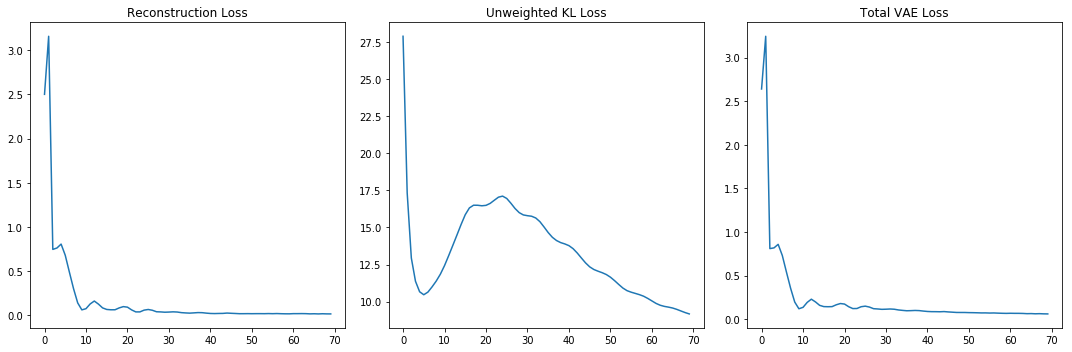

In [6]:
# Plot of losses
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.plot(losses_rc)
plt.title('Reconstruction Loss')

plt.subplot(132)
plt.plot([np.mean(i) for i in losses_kl])
plt.title('Unweighted KL Loss')

plt.subplot(133)
plt.plot([np.mean(i) for i in losses])
plt.title('Total VAE Loss')
plt.tight_layout()